In [1]:
import gc
import os
import re

import numpy as np
import pandas as pd
import torch

from __init__ import *
from dataloader import *
from model import *
from utilis import *
from inference import *
import torchsummary

# Backtesting
***
1. 把5d的模型结果弄下来，跑列表数据
2. 写分组的代码
3. 更新report
4. 有时间合并一下数据得到市值加权return

In [10]:
df_5D2C = pd.read_csv(r'result/CNN5D2C_results_new.csv', index_col=0)#.reset_index(drop=True)
df_5D2C

,Date,StockID,Ret_5d,label,label_pre,label_0_prob,label_1_prob,MarketCap
0,2002-01-31,10001,-0.070266,0,0,0.122837,-0.324118,2.899580e+04
1,2002-02-28,10001,-0.018691,0,0,0.256071,0.007112,2.748830e+04
2,2002-03-28,10001,-0.013327,0,1,-0.161311,-0.039841,2.673840e+04
3,2002-04-30,10001,-0.020201,0,0,0.288541,0.069019,2.558145e+04
4,2002-05-31,10001,-0.034415,0,0,0.407260,-0.211303,2.596067e+04
...,...,...,...,...,...,...,...,...
1308289,2019-08-30,93436,0.027392,1,1,-0.178833,0.067946,4.041284e+07
1308290,2019-09-30,93436,-0.013078,0,1,-0.202326,0.102356,4.335660e+07
1308291,2019-10-31,93436,0.065478,1,1,-0.023954,0.046154,5.676276e+07
1308292,2019-11-29,93436,0.018034,1,1,-0.191739,0.146275,5.947004e+07


In [12]:
def back_testing(df: pd.DataFrame, label_='Ret_20d'):
    df_res = pd.DataFrame()
    for date_g, df_g in df.groupby('Date'):
        df_g = df_g.dropna()
        equal_ret = np.mean(df_g[label_]).round(6)
        market_ret = np.mean((df_g[label_] * df_g['MarketCap']) / sum(df_g['MarketCap'])).round(8)
        long_ret = np.mean(df_g[df_g['label_1_prob'] > df_g['label_1_prob'].quantile(0.9)][label_]).round(6)
        short_ret = np.mean(df_g[df_g['label_0_prob'] > df_g['label_0_prob'].quantile(0.9)][label_]).round(6)
        long_short = round(long_ret - short_ret, 6)

        df_res.loc[len(df_res), ['Date', 'equal_ret', 'market_ret', 'long_ret', 'short_ret', 'long_short']] = (date_g,
                                                                                                               equal_ret,
                                                                                                               market_ret,
                                                                                                               long_ret,
                                                                                                               short_ret,
                                                                                                               long_short)
    return df_res.sort_values(by=['Date'], ascending=True)

CNN5D2C_backtest = back_testing(df_5D2C, label_='Ret_5d')
CNN5D2C_backtest

,Date,equal_ret,market_ret,long_ret,short_ret,long_short
0,2002-01-31,-0.041687,-6.190000e-06,-0.031860,-0.043924,0.012064
1,2002-02-28,0.046475,6.660000e-06,0.074265,0.022270,0.051995
2,2002-03-28,-0.011813,-2.850000e-06,-0.000027,-0.022040,0.022013
3,2002-04-30,-0.018408,-3.510000e-06,-0.019699,-0.027626,0.007927
4,2002-05-31,-0.035311,-5.070000e-06,-0.033270,-0.045449,0.012179
...,...,...,...,...,...,...
211,2019-08-30,0.022468,2.950000e-06,0.030938,0.012811,0.018127
212,2019-09-30,-0.017545,-2.190000e-06,-0.012704,-0.026435,0.013731
213,2019-10-31,0.016719,2.880000e-06,0.028424,-0.000979,0.029403
214,2019-11-29,0.003574,2.300000e-07,0.003805,-0.007119,0.010924


In [13]:
CNN5D2C_backtest.to_csv('CNN5D2C_backtesting.csv')

In [37]:
df_5d2c = pd.read_csv('CNN5D2C_backtesting.csv', index_col=0)
df_5d2c

,Date,equal_ret,market_ret,long_ret,short_ret,long_short
0,2002-01-31,-0.041687,-6.190000e-06,-0.031860,-0.043924,0.012064
1,2002-02-28,0.046475,6.660000e-06,0.074265,0.022270,0.051995
2,2002-03-28,-0.011813,-2.850000e-06,-0.000027,-0.022040,0.022013
3,2002-04-30,-0.018408,-3.510000e-06,-0.019699,-0.027626,0.007927
4,2002-05-31,-0.035311,-5.070000e-06,-0.033270,-0.045449,0.012179
...,...,...,...,...,...,...
211,2019-08-30,0.022468,2.950000e-06,0.030938,0.012811,0.018127
212,2019-09-30,-0.017545,-2.190000e-06,-0.012704,-0.026435,0.013731
213,2019-10-31,0.016719,2.880000e-06,0.028424,-0.000979,0.029403
214,2019-11-29,0.003574,2.300000e-07,0.003805,-0.007119,0.010924


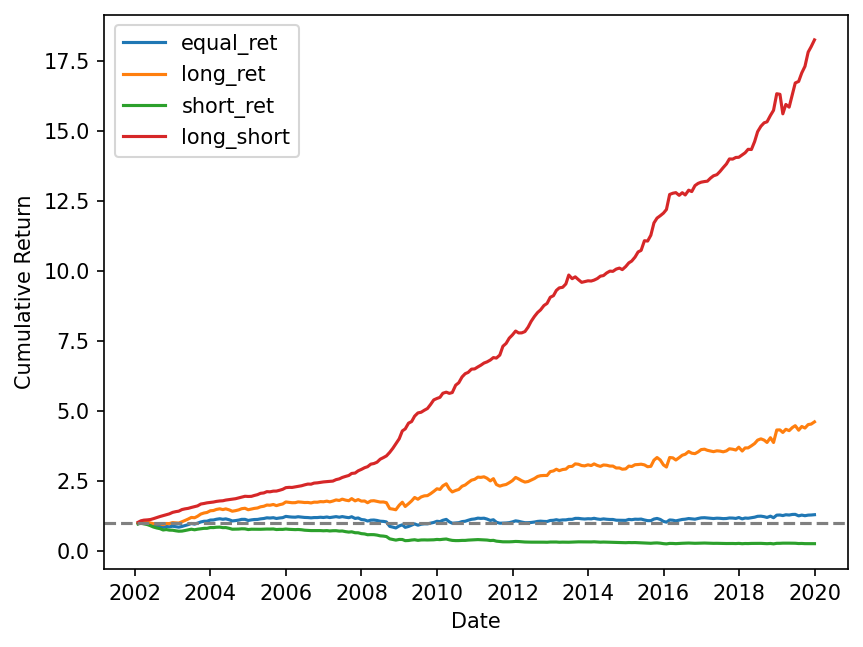

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def back_test_plot(df):
    df['Date'] = pd.to_datetime(df['Date'])
    fig, ax = plt.subplots(dpi=150)
    # plt.figure(dpi=150)
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # 设置x轴刻度间隔为5天
    # ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    for col in ['equal_ret', 'long_ret', 'short_ret', 'long_short']:
        y = (1 + df[col]).cumprod()
        plt.plot(df['Date'], y, label=col)
    ax.axhline(y=1, color = 'gray', linestyle='--')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # plt.title('CNN20D2C Model Performance')
    plt.show()

back_test_plot(df_5d2c)

# Test Result
***
**calculate**:
    - Test loss
    - Test acc
    - Test f1 score
    - True positive
    - False negative
    - 2002-2005acc,
    - 2005-2011acc,
    - 2012-2019acc


In [39]:
def test_result(df):
    # loss 自己算
    acc = accuracy_score(df['label'], df['label_pre']).__round__(4)
    t_num = len(df[df['label'] == 1])
    t_p_num = len(df[(df['label'] == 1) & (df['label_pre'] == 1)])
    t_p_r = (t_p_num / t_num).__round__(4)

    f_num = len(df[df['label'] == 0])
    t_n_num = len(df[(df['label'] == 0) & (df['label_pre'] == 0)])
    t_n_r = (t_n_num / f_num).__round__(4)


    acc_tn = accuracy_score(df[df['label'] == 0]['label'], df[df['label']==0]['label_pre']).__round__(4)

    f1 = f1_score(df['label'], df['label_pre'], average='macro').__round__(4)

    t_acc = []
    df['Date'] = pd.to_datetime(df['Date'])
    for t_r in [pd.date_range('2002-01-01', '2006-01-01'), pd.date_range('2006-01-01', '2012-01-01'), pd.date_range('2012-01-01', '2020-01-01')]:
        df_t = df[df['Date'].isin(t_r)]
        t_acc.append(accuracy_score(df_t['label'], df_t['label_pre']).__round__(4))

    df_res = pd.DataFrame()
    df_res.loc[0, 'acc'] = acc
    df_res.loc[0, 'acc_tp'] = f'{t_p_r} ({t_p_num}/{t_num})'
    df_res.loc[0, 'acc_tn'] = f'{t_n_r} ({t_n_num}/{f_num})'
    df_res.loc[0, 'f1_score'] = f1
    df_res.loc[0, ['acc(02-05)', 'acc(06-11)', 'acc(12-19)']] = t_acc

    return df_res



In [42]:
df_l = {}
for res_f in os.listdir(r'./result'):
    df_model = pd.read_csv(os.path.join(r'./result', res_f), index_col=0)
    df_l[f'{res_f[:-16]}'] = test_result(df_model)
    del df_model
    gc.collect()
df_test_res = pd.concat(df_l.values(), keys=df_l.keys())
df_test_res

,,acc,acc_tp,acc_tn,f1_score,acc(02-05),acc(06-11),acc(12-19)
CNN20D2C,0,0.5274,0.5305 (362083/682552),0.524 (325009/620300),0.5270,0.5237,0.5435,0.5163
CNN20D3C,0,0.5215,0.5 (341275/682552),0.5526 (342784/620300),0.3569,0.5159,0.5383,0.5110
CNN5D2C,0,0.5339,0.673 (447003/664242),0.3905 (251472/644052),0.5232,0.5438,0.5346,0.5273


In [43]:
df_test_res.to_csv('all_model_test_results.csv')

# Checking
***

In [3]:
model = CNN20DModel(2)
print(model)

CNN20DModel(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(3, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(3, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), strid

In [7]:
torchsummary.summary(model.to(torch.device('cuda')), (1, 64, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 21, 60]           1,024
            Conv2d-2           [-1, 64, 21, 60]           1,024
       BatchNorm2d-3           [-1, 64, 21, 60]             128
       BatchNorm2d-4           [-1, 64, 21, 60]             128
         LeakyReLU-5           [-1, 64, 21, 60]               0
         LeakyReLU-6           [-1, 64, 21, 60]               0
         MaxPool2d-7           [-1, 64, 10, 60]               0
         MaxPool2d-8           [-1, 64, 10, 60]               0
            Conv2d-9          [-1, 128, 10, 60]         123,008
           Conv2d-10          [-1, 128, 10, 60]         123,008
      BatchNorm2d-11          [-1, 128, 10, 60]             256
      BatchNorm2d-12          [-1, 128, 10, 60]             256
        LeakyReLU-13          [-1, 128, 10, 60]               0
        LeakyReLU-14          [-1, 128,

# Configs setting
***

In [2]:
settings_20d2c = {'DATA': {'IMG_FILE': r'/kaggle/input/dataset-of-reimaging-price-trend',
                     'IMAGE_WIDTH': {5: 15, 20: 60, 60: 180},
                     'IMAGE_HEIGHT': {5: 32, 20: 64, 60: 96},
                     'COLUMNS': ['Date', 'StockID', 'Ret_20d', 'label'],  #
                     'TARGET': 'Ret_20d',  # predicting target
                     'TRAIN_YEAR': [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001]
                           },
                'PATH': {'LOGGER': r'./log',  # save logger info
                         'MODEL': r'./model',  # save model parameters & train/valid loss
                         'RESULT': r'./result',  # save testing/backtest result
                         },
                'TRAIN': {'SEED': 1023,
                          'MODEL_NAME': 'CNN20D2C',
                          'LR': 1e-5,
                          'KFOLD': 3,
                          'EPOCHS': 13,
                          'BATCH_SIZE': 128,
                          'NUM_WORKERS': 0,
                          'WEIGHT_DECAY': 1e-3,
                          'OUT_FEATURES': 2  # output classification num
                          },
                'INFERENCE': {'TEST_YEAR': [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
                              'BACK_TEST_YEAR': None
                              }}

settings_20d3c = {'DATA': {'IMG_FILE': r'/kaggle/input/dataset-of-reimaging-price-trend',
                           # 'IMG_FILE': r'.\\img_data\\monthly_20d',
                           'IMAGE_WIDTH': {5: 15, 20: 60, 60: 180},
                           'IMAGE_HEIGHT': {5: 32, 20: 64, 60: 96},
                           'COLUMNS': ['Date', 'StockID', 'Ret_20d', 'label'],  #
                           'TARGET': 'Ret_20d',  # predicting target
                           'TRAIN_YEAR': [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001],
                           'TEST_YEAR': [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                           },
                'PATH': {'LOGGER': r'./log',  # save logger info
                         'MODEL': r'/kaggle/input/model-price-in-trend/model',  # save model parameters & train/valid loss
                         'MODEL_LOADING': r'/kaggle/input/model-price-in-trend/model',  # loading path
                         'RESULT': r'./result',  # save testing/backtest result
                         },
                'TRAIN': {'SEED': 1023,
                          'MODEL_NAME': 'CNN20D3C',
                          'LR': 1e-5,
                          'KFOLD': 3,
                          'EPOCHS': 13,
                          'BATCH_SIZE': 128,
                          'NUM_WORKERS': 4,
                          'WEIGHT_DECAY': 1e-3,
                          'OUT_FEATURES': 3  # output classification num
                          },
                'INFERENCE': {'BACK_TEST_YEAR': None
                              }}

settings_5d2c = {'DATA': {'IMG_FILE': r'/kaggle/input/dataset-of-reimaging-price-trend',
                          'IMAGE_WIDTH': {5: 15, 20: 60, 60: 180},
                          'IMAGE_HEIGHT': {5: 32, 20: 64, 60: 96},
                          'COLUMNS': ['Date', 'StockID', 'Ret_5d', 'label'],  #
                          'TARGET': 'Ret_5d',  # predicting target
                          'TRAIN_YEAR': [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001],
                          'TEST_YEAR': [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
                           },
                'PATH': {'LOGGER': r'./log',  # save logger info
                         'MODEL': r'./model',  # save model parameters & train/valid loss
                         'RESULT': r'./result',  # save testing/backtest result
                         },
                'TRAIN': {'SEED': 1023,
                          'MODEL_NAME': 'CNN5D2C',
                          'LR': 1e-5,
                          'KFOLD': 3,
                          'EPOCHS': 13,
                          'BATCH_SIZE': 128,
                          'NUM_WORKERS': 4,
                          'WEIGHT_DECAY': 1e-3,
                          'OUT_FEATURES': 2  # output classification num
                          },
                'INFERENCE': {'TEST_YEAR': [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
                              'BACK_TEST_YEAR': None
                              }}

In [3]:
with open('./configs/CNN20D2C.yaml', 'w', encoding='utf-8') as f:
    data = yaml.dump(settings_20d2c, f)

with open('./configs/CNN20D3C.yaml', 'w', encoding='utf-8') as f:
    data = yaml.dump(settings_20d3c, f)

with open('./configs/CNN5D2C.yaml', 'w', encoding='utf-8') as f:
    data = yaml.dump(settings_5d2c, f)

In [3]:
# settings = yaml.load(open('20D3C.yaml', 'r'), Loader=yaml.FullLoader)
# settings

In [ ]:
# image_test, label_test = get_data(settings_20d2c['INFERENCE']['TEST_YEAR'],
#                                   settings_20d2c['DATA']['TARGET'],
#                                   settings_20d2c['DATA']['IMG_FILE'],
#                                   settings_20d2c['DATA']['IMAGE_HEIGHT'],
#                                   settings_20d2c['DATA']['IMAGE_WIDTH'],
#                                   settings_20d2c['DATA']['COLUMNS'])
# image_test.shape

# Inference
***

In [1]:
from __init__ import *
from dataloader import *
from model import *
from utilis import *
from inference import *

In [ ]:
%run main.py -s ./configs/CNN20D3C.yaml -i

INFO Using device: cuda. ]
INFO ========================= Model Inference =========================]
INFO ------------------ model_fold_0_9_0.524.pth testing ----------------]
